# Finance Application
This application uses a Flax BNN with stochastic Stein VI to predict buy/sell signals on historical stock-data. We then proceed with a backtest to find out how our model would have performed on out-of-sample data.

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from flax import linen as nn
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from modules.evaluation_functions.bnn_functions import *
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

from modules.application_functions.finance_functions import *

Downloading historical stock prices, using the Yahoo-Finance package:

In [23]:
target = "XOM" #SPY
daily_prices = yf.download(target)
full_df = daily_prices["2007-01-01":]
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,76.260002,76.269997,73.510002,74.110001,40.657730,30510700
2007-01-04,73.849998,73.900002,72.209999,72.720001,39.895161,31046600
2007-01-05,72.449997,73.379997,72.220001,73.239998,40.180439,24671500
2007-01-08,73.879997,74.250000,71.849998,72.650002,39.856758,25981900
2007-01-09,71.849998,72.839996,71.440002,72.089996,39.549526,27039900
...,...,...,...,...,...,...
2024-02-26,103.720001,104.940002,103.050003,104.250000,104.250000,13360800
2024-02-27,104.680000,105.150002,103.849998,104.029999,104.029999,16360000
2024-02-28,104.470001,105.430000,104.000000,104.320000,104.320000,14810500


Checking for errors:

In [24]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

Creating buy/sell signals on the data, using the triple-barrier-method:

In [25]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,upper_bound,lower_bound
Date,,,,,,,,,,
2007-01-05,72.449997,73.379997,72.220001,73.239998,40.180439,24671500,0.018319,0,75.923322,71.227505
2007-01-08,73.879997,74.250000,71.849998,72.650002,39.856758,25981900,0.012741,0,74.501312,71.261519
2007-01-09,71.849998,72.839996,71.440002,72.089996,39.549526,27039900,0.010166,0,73.555670,70.990741
2007-01-10,71.809998,73.110001,70.639999,70.989998,38.946068,30572000,0.009517,1,72.341277,69.976539
2007-01-11,70.989998,72.849998,70.769997,70.980003,38.940582,29161700,0.009138,1,72.277205,70.007102
...,...,...,...,...,...,...,...,...,...,...
2024-02-09,104.099998,104.839996,101.699997,101.769997,100.832893,20410500,0.013275,1,104.471930,99.743546
2024-02-12,102.160004,103.400002,102.000000,103.169998,102.220001,18173100,0.013263,0,105.906584,101.117559
2024-02-13,102.760002,103.089996,100.599998,101.339996,101.339996,18917400,0.013891,1,104.155359,99.228474


Plotting the buy-signals since 2022 for demonstration:

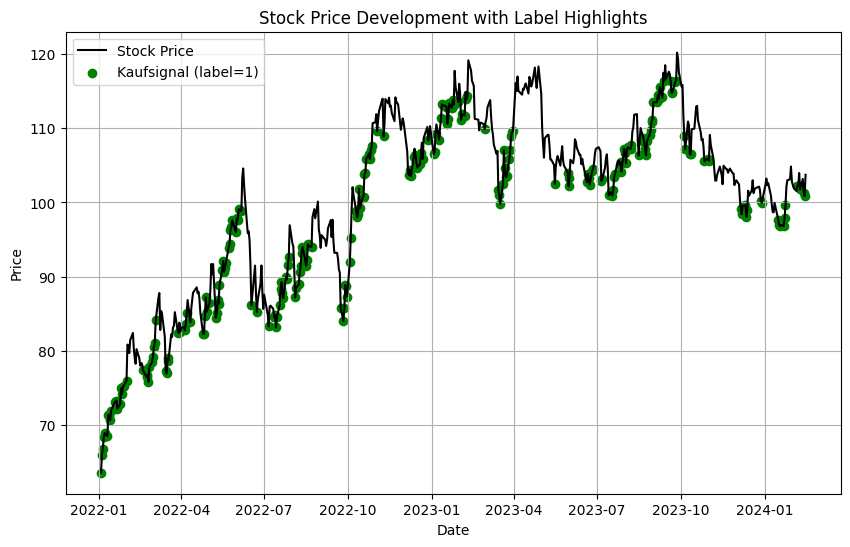

In [26]:
plot_df = full_df["2022-01-01":]

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[plot_df['label'] == 1].index, plot_df[plot_df['label'] == 1]['Close'], color='green', label='Kaufsignal (label=1)')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Creating more indicator variables using the ichimoku-cloud-system:

In [27]:
full_df = ichimoku(full_df)
full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,upper_bound,lower_bound,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-05,72.449997,73.379997,72.220001,73.239998,40.180439,24671500,0.018319,0,75.923322,71.227505,...,0,0,NaN,NaN,0,0,0,0,0,0
2007-01-08,73.879997,74.250000,71.849998,72.650002,39.856758,25981900,0.012741,0,74.501312,71.261519,...,0,0,NaN,NaN,0,0,0,0,0,0
2007-01-09,71.849998,72.839996,71.440002,72.089996,39.549526,27039900,0.010166,0,73.555670,70.990741,...,0,0,NaN,NaN,0,0,0,0,0,0
2007-01-10,71.809998,73.110001,70.639999,70.989998,38.946068,30572000,0.009517,1,72.341277,69.976539,...,0,0,NaN,NaN,0,0,0,0,0,0
2007-01-11,70.989998,72.849998,70.769997,70.980003,38.940582,29161700,0.009138,1,72.277205,70.007102,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09,104.099998,104.839996,101.699997,101.769997,100.832893,20410500,0.013275,1,104.471930,99.743546,...,0,0,-3.035004,-5.400005,0,0,0,0,0,0
2024-02-12,102.160004,103.400002,102.000000,103.169998,102.220001,18173100,0.013263,0,105.906584,101.117559,...,0,0,-2.710003,-5.075005,0,0,0,0,0,0
2024-02-13,102.760002,103.089996,100.599998,101.339996,101.339996,18917400,0.013891,1,104.155359,99.228474,...,0,0,-1.550003,-3.895004,0,0,0,0,0,0


Creating percentage-changes and dropping columns for the training:

In [28]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [29]:
full_df.dropna(inplace=True)
backtest_df = full_df.copy()
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', "upper_bound", "lower_bound"], axis=1, inplace=True)

In [30]:
full_df

,vola,label,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,tenkan_sen_higher_close,kijun_sen_higher_close,senkou_span_a_higher_close,senkou_span_b_higher_close,...,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud,close_pct,Volume_pct
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,0.011430,1,0.000127,0.006868,0.005521,0.000000,0,0,0,0,...,6.455002,5.135002,0,0,0,0,0,0,-0.012195,0.321168
2007-05-01,0.010884,1,0.000000,0.000000,0.001727,0.000000,0,0,0,0,...,6.455002,5.135002,0,0,0,0,0,0,0.003527,0.117389
2007-05-02,0.010353,0,0.005379,0.002767,0.000931,0.000000,0,0,0,0,...,6.857500,5.327501,0,0,0,0,1,1,0.002008,-0.275717
2007-05-03,0.010198,0,0.003399,0.000257,0.000964,0.000000,0,0,0,0,...,7.057501,5.277502,0,0,0,0,0,0,0.010774,0.014339
2007-05-04,0.009791,1,0.005269,0.005389,0.001480,0.001034,0,0,0,0,...,7.370003,5.590004,0,0,0,0,0,0,-0.001611,0.113941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09,0.013275,1,0.000000,0.000000,-0.001378,0.000000,1,0,0,1,...,-3.035004,-5.400005,0,0,0,0,0,0,-0.021160,0.039395
2024-02-12,0.013263,0,0.000000,0.000000,0.001552,-0.003074,0,0,0,1,...,-2.710003,-5.075005,0,0,0,0,0,0,0.013757,-0.109620
2024-02-13,0.013891,1,-0.000195,0.000000,-0.000812,-0.011195,1,0,1,1,...,-1.550003,-3.895004,0,0,0,0,0,0,-0.017738,0.040956


Creating our test- and train-datasets:

In [31]:
test_begin = "2021-01-01"
train_df = full_df[:test_begin]
test_df = full_df[test_begin:]

In [32]:
Xs_train = train_df.drop('label', axis=1).values
Xs_test = test_df.drop('label', axis=1).values
Ys_train = train_df['label'].values
Ys_test = test_df['label'].values

# MLP
Creating the Flax BNN:

In [33]:
# MLP params
hidden_layer_width = 15
n_hidden_layers = 5

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

Training our model with stochastic Stein VI:

In [34]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid= None, num_steps=1000,batch_size_particles = 75, batch_size_data = 64, num_particles=400
    )

Ys_pred_train, Ys_pred_test, _, Ys_probabilities_train, Ys_probabilities_test = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 1000/1000 [05:56<00:00,  2.80it/s]


Adjusting the threshhold to classify signals as "buy", according to what would have been best on the train dataset:

In [35]:
#Create a Precision/Recall curve for our training data
precision_train, recall_train, pr_thresholds_train = skm.precision_recall_curve(Ys_train, Ys_probabilities_train)
fscore_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

#Find optimal thresh on PR curve train
ix = np.argmax(fscore_train)
optimal_threshold = pr_thresholds_train[ix]
optimal_threshold

0.325

In [36]:
test_signal_predictions_adj = Ys_probabilities_test > optimal_threshold

Plotting the found signals on the test-dataset:

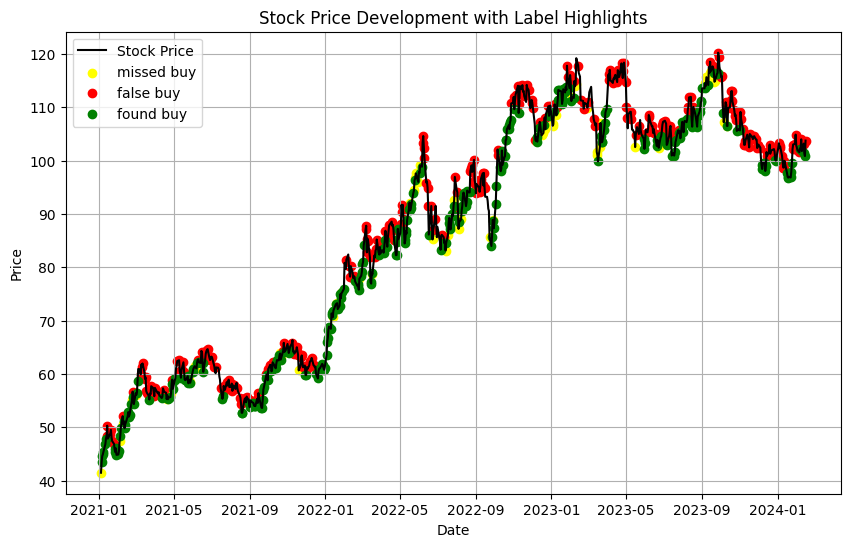

In [37]:
# Add Close prices back to df to see the visualization
plot_df = backtest_df[test_begin:]
plot_df["signal"] = test_signal_predictions_adj.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)]['Close'], color='yellow', label='missed buy')
plt.scatter(plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)]['Close'], color='red', label='false buy')
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)]['Close'], color='green', label='found buy')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [38]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Train accuracy = 63.72%
Test accuracy = 54.90%


# Backtest
Running a backtest using the triple-barrier-method and our found signals on the test-dataset:

In [39]:
i = 0
cash = plot_df["Close"][0]
percentage_invested = 0.5

cash_history = []
while i < (len(plot_df)-investment_horizon):
    cash_history.append(cash)
    if plot_df["signal"][i] == 1:
        invest_sum = percentage_invested*cash
        cash_vorr = cash - invest_sum
        buy_price = plot_df["Close"][i]

        z=1
        while z <= investment_horizon:
            if plot_df["Close"][i+z] >= plot_df["upper_bound"][i]:
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            elif plot_df["Close"][i+z] <= plot_df["lower_bound"][i]:
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            elif (z == investment_horizon):
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            z = z+1
            cash_history.append(cash)
        i = i+z
    i = i+1

plot_df = plot_df[:i]
plot_df["cash"] = cash_history

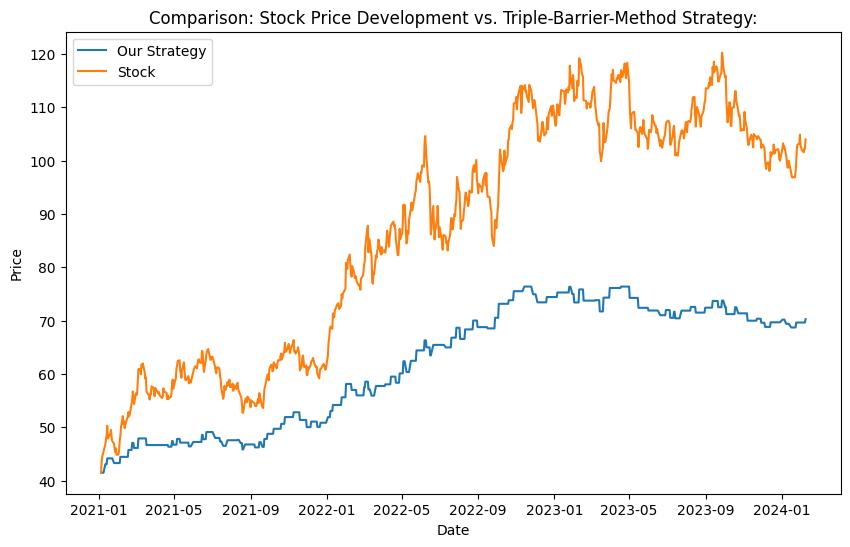

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['cash'], label = "Our Strategy")
plt.plot(plot_df.index, plot_df['Close'], label = "Stock")
plt.title('Comparison: Stock Price Development vs. Triple-Barrier-Method Strategy:')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()